<a href="https://www.vivaair.com"><img src = "https://upload.wikimedia.org/wikipedia/commons/a/a1/Logosvivaair_Mesa-de-trabajo-1.png" width = 250, align = "Right"></a>

# Fuel Policy / Analytics - OCC
    
***
    
### Descripción:
Este Notebook tiene como objetivo analizar las variables a tener en cuenta para la pólitica de consumo de combustible para la aerolínea <a href="www.vivaair.com">Viva Air </a>



## 1. Exploration Data Analysis

In [1]:
#Librerias a utilizar

import warnings; warnings.simplefilter('ignore')
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os, shutil, datetime
import scipy.stats as stats

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
#Lectura de archivo Master
Master=pd.read_excel('Master Data Base - Viva Air.xlsx')
Master.drop(columns=['Unnamed: 0','Wind Dir','Op constraint','Snow'],inplace=True)
Master_Copy=Master.copy()
Master.head()

,Add Fuel,Flight,Date,Leg,Op,O,D,Year,Month,Day,ATD,ATA,Flight Time,Distance,LF,Pax,Type AC,AC,Fuel Burn mean,Fuel Burn std,Fuel Burn min,Fuel Burn P25,Fuel Burn Median,Fuel Burn P75,Fuel Burn max,Fuel Penalty,Temperature,Wind,H Vsby,V Vsby,Rain,Fog-Brume,Thunder,Flight Time mean,Flight Time std,Flight Time min,Flight Time P25,Flight Time median,Flight Time P75,Flight Time max
0,448.045758,8326,2019-07-01,BOGADZ,VVC,BOG,ADZ,2019,7,7,0,2,108.0,652,100,188,New,HK-5320,4261.206442,441.539455,1220,4100.0,4190.0,4370.0,10200,49.0,28.0,7.0,6.21,1400,0,0,0,102.542042,5.758462,96.0,100.0,101.0,103.0,165.0
1,200.000000,8327,2019-07-01,ADZBOG,VVC,ADZ,BOG,2019,7,7,3,5,103.0,652,100,188,New,HK-5320,4320.552437,285.117336,3280,4150.0,4250.0,4470.0,8560,50.0,12.0,6.0,6.21,1700,0,0,0,100.855655,4.905819,89.0,98.0,100.0,103.0,133.0
2,97.276265,748,2019-07-01,LIMCUZ,VPE,LIM,CUZ,2019,7,7,4,5,61.0,316,70,132,New,HK-5277,2683.991471,951.931563,730,2490.0,2580.0,2700.0,8360,28.0,2.0,1.0,6.21,3000,0,0,0,57.689011,6.443030,43.0,54.0,56.0,59.0,133.0
3,0.000000,110,2019-07-01,LIMCIX,VPE,LIM,CIX,2019,7,7,4,6,63.0,353,71,135,New,HK-5286,2872.830508,978.509750,810,2669.0,2760.0,2876.5,8930,32.0,17.0,2.0,6.21,5000,0,0,0,63.250871,1.833962,58.0,62.0,63.0,64.0,70.0
4,29.013540,800,2019-07-01,LIMAQP,VPE,LIM,AQP,2019,7,7,5,6,65.0,414,82,156,New,HK-5273,3035.769231,1055.309470,720,2880.0,2950.0,3030.0,10100,34.0,10.0,7.0,6.21,13000,0,0,0,64.841880,3.663671,60.0,64.0,65.0,66.0,115.0


In [3]:
#Check missing data
missing_data = Master.isnull()
for column in Master.columns[Master.isnull().any()].tolist():
    print (missing_data[column].value_counts())

In [4]:
Master=Master_Copy.copy()
rows=Master.shape[0]

#Se toma valor de referencia dado que hay muy pocos casos donde se obtuvo cantidades superiores a este valor
Ref_value=500

Master.insert(1,'Add Fuel Label',[Ref_value if x>Ref_value else int(np.ceil(x/100)*100) for x in Master['Add Fuel']])
Master.insert(2,'Add Fuel Dummy',[1 if x>0 else 0 for x in Master['Add Fuel Label']])

#Master=Master[Master['Add Fuel']<=Ref_value]
#print("Drop",rows-Master.shape[0],"rows (Outliers)")

Master['New AC']=pd.get_dummies(Master['Type AC'], columns=['Type AC']).iloc[:,0]
Master.drop(columns='Type AC',inplace=True)

Master=pd.get_dummies(Master, columns=['Op'],drop_first=True)
Master.rename(columns={"Op_VVC":"VVC"},inplace=True)

Master['Long Flight Time']=[1 if x>130 else 0 for x in Master['Flight Time']]

for i in ['Rain','Fog-Brume','Thunder']:
    Master[i]=(Master[i]/100).apply(int)
    
Master['Flight Time Range']=Master['Flight Time max']-Master['Flight Time min'] 
Master['Fuel Burn Range']=Master['Fuel Burn max']-Master['Fuel Burn min'] 


In [5]:
Master.head()

,Add Fuel,Add Fuel Label,Add Fuel Dummy,Flight,Date,Leg,O,D,Year,Month,Day,ATD,ATA,Flight Time,Distance,LF,Pax,AC,Fuel Burn mean,Fuel Burn std,Fuel Burn min,Fuel Burn P25,Fuel Burn Median,Fuel Burn P75,Fuel Burn max,Fuel Penalty,Temperature,Wind,H Vsby,V Vsby,Rain,Fog-Brume,Thunder,Flight Time mean,Flight Time std,Flight Time min,Flight Time P25,Flight Time median,Flight Time P75,Flight Time max,New AC,VVC,Long Flight Time,Flight Time Range,Fuel Burn Range
0,448.045758,500,1,8326,2019-07-01,BOGADZ,BOG,ADZ,2019,7,7,0,2,108.0,652,100,188,HK-5320,4261.206442,441.539455,1220,4100.0,4190.0,4370.0,10200,49.0,28.0,7.0,6.21,1400,0,0,0,102.542042,5.758462,96.0,100.0,101.0,103.0,165.0,1,1,0,69.0,8980
1,200.000000,200,1,8327,2019-07-01,ADZBOG,ADZ,BOG,2019,7,7,3,5,103.0,652,100,188,HK-5320,4320.552437,285.117336,3280,4150.0,4250.0,4470.0,8560,50.0,12.0,6.0,6.21,1700,0,0,0,100.855655,4.905819,89.0,98.0,100.0,103.0,133.0,1,1,0,44.0,5280
2,97.276265,100,1,748,2019-07-01,LIMCUZ,LIM,CUZ,2019,7,7,4,5,61.0,316,70,132,HK-5277,2683.991471,951.931563,730,2490.0,2580.0,2700.0,8360,28.0,2.0,1.0,6.21,3000,0,0,0,57.689011,6.443030,43.0,54.0,56.0,59.0,133.0,1,0,0,90.0,7630
3,0.000000,0,0,110,2019-07-01,LIMCIX,LIM,CIX,2019,7,7,4,6,63.0,353,71,135,HK-5286,2872.830508,978.509750,810,2669.0,2760.0,2876.5,8930,32.0,17.0,2.0,6.21,5000,0,0,0,63.250871,1.833962,58.0,62.0,63.0,64.0,70.0,1,0,0,12.0,8120
4,29.013540,100,1,800,2019-07-01,LIMAQP,LIM,AQP,2019,7,7,5,6,65.0,414,82,156,HK-5273,3035.769231,1055.309470,720,2880.0,2950.0,3030.0,10100,34.0,10.0,7.0,6.21,13000,0,0,0,64.841880,3.663671,60.0,64.0,65.0,66.0,115.0,1,0,0,55.0,9380


In [6]:
a=Master.copy()
a['y4']=[Ref_value if x>Ref_value else int(np.ceil(x/100)*100) for x in Master['Add Fuel']]

In [7]:
a.groupby(by='y4')['y4'].count()

y4
0      15296
100     6207
200     3730
300     2031
400     1016
500     1104
Name: y4, dtype: int64

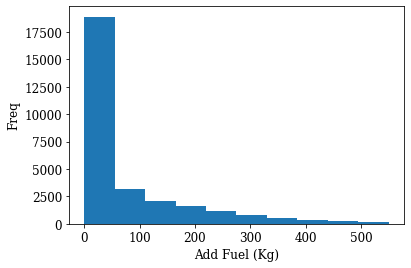

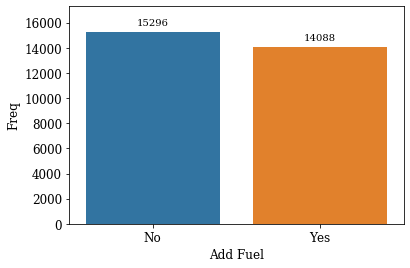

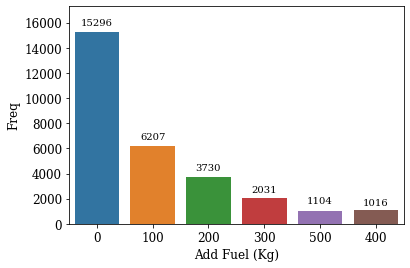

In [8]:
#Add fuel Plots

for j in ['Add Fuel','Add Fuel Dummy','Add Fuel Label']:
    fig = plt.figure()
    
    if j=='Add Fuel':
        ax=Master[Master[j]<=Ref_value+50][j].plot.hist()
    else:
        count=Master[j].value_counts()
        ax=sns.countplot(Master[j])
        labels=[]
        for i,label in enumerate(count.index):
            #print(i,label)
            plt.text(i,count[label]+500,count[label],ha='center',family="serif")
            plt.ylim(0,Master['Add Fuel Label'].value_counts().max()+2000)
            labels.append(label)
        ax.set_xticklabels(labels)

    plt.xticks(family="serif",fontsize=12)
    plt.yticks(family="serif",fontsize=12)
    ax.set_ylabel("Freq",family="serif",fontsize=12)
    if j=='Add Fuel Dummy':
        ax.set_xlabel("Add Fuel",family="serif",fontsize=12)
        ax.set_xticklabels(['No','Yes'])
    else:
        ax.set_xlabel("Add Fuel (Kg)",family="serif",fontsize=12)
        

plt.show()

1 100
2 200
3 300
4 500
5 400


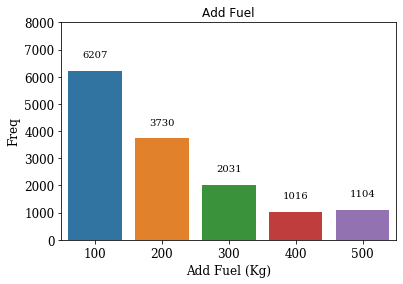

In [9]:
#Add fuel Plots

for j in ['Add Fuel Label']:
    fig = plt.figure()
    
    if j=='Add Fuel':
        ax=Master[Master[j]<=Ref_value+50][j].plot.hist()
    else:
        count=Master[j].value_counts()
        ax=sns.countplot(Master[Master[j]>0][j])
        labels=[]
        pos=0
        for i,label in enumerate(count.index):
            if label>0:
                print(i,label)
                if i==4:
                    pos=5
                elif i==5:
                    pos=4
                else:
                    pos=i
                plt.text(pos-1,count[label]+500,count[label],ha='center',family="serif")
                plt.ylim(0,8000)
                labels.append(label)
       
    plt.title("Add Fuel")
    plt.xticks(family="serif",fontsize=12)
    plt.yticks(family="serif",fontsize=12)
    ax.set_ylabel("Freq",family="serif",fontsize=12)
    if j=='Add Fuel Dummy':
        ax.set_xlabel("Add Fuel",family="serif",fontsize=12)
        ax.set_xticklabels(['No','Yes'])
    else:
        ax.set_xlabel("Add Fuel (Kg)",family="serif",fontsize=12)
        

plt.show()

In [10]:
for i,label in enumerate(count.index):
    print(i,label)

0 0
1 100
2 200
3 300
4 500
5 400


In [11]:
Master.columns

Index(['Add Fuel', 'Add Fuel Label', 'Add Fuel Dummy', 'Flight', 'Date', 'Leg',
       'O', 'D', 'Year', 'Month', 'Day', 'ATD', 'ATA', 'Flight Time',
       'Distance', 'LF', 'Pax', 'AC', 'Fuel Burn mean', 'Fuel Burn std',
       'Fuel Burn min', 'Fuel Burn P25', 'Fuel Burn Median', 'Fuel Burn P75',
       'Fuel Burn max', 'Fuel Penalty', 'Temperature', 'Wind', 'H Vsby',
       'V Vsby', 'Rain', 'Fog-Brume', 'Thunder', 'Flight Time mean',
       'Flight Time std', 'Flight Time min', 'Flight Time P25',
       'Flight Time median', 'Flight Time P75', 'Flight Time max', 'New AC',
       'VVC', 'Long Flight Time', 'Flight Time Range', 'Fuel Burn Range'],
      dtype='object')

In [12]:
'''
con_var=['Add Fuel', 'Fuel Burn mean', 'Fuel Burn std','Fuel Burn min', 'Fuel Burn P25', 'Fuel Burn Median', 'Fuel Burn P75',
 'Fuel Burn max','Fuel Burn Range', 'Fuel Penalty','Distance','Flight Time','Flight Time mean','Flight Time std', 'Flight Time min', 
 'Flight Time P25','Flight Time median', 'Flight Time P75','Flight Time max','Flight Time Range','LF', 'Pax','Temperature','Wind','H Vsby','V Vsby']
 '''

"\ncon_var=['Add Fuel', 'Fuel Burn mean', 'Fuel Burn std','Fuel Burn min', 'Fuel Burn P25', 'Fuel Burn Median', 'Fuel Burn P75',\n 'Fuel Burn max','Fuel Burn Range', 'Fuel Penalty','Distance','Flight Time','Flight Time mean','Flight Time std', 'Flight Time min', \n 'Flight Time P25','Flight Time median', 'Flight Time P75','Flight Time max','Flight Time Range','LF', 'Pax','Temperature','Wind','H Vsby','V Vsby']\n "

In [13]:
con_var=['Add Fuel', 'Fuel Penalty','Distance','Flight Time','LF', 'Pax','Temperature','Wind','H Vsby','V Vsby']

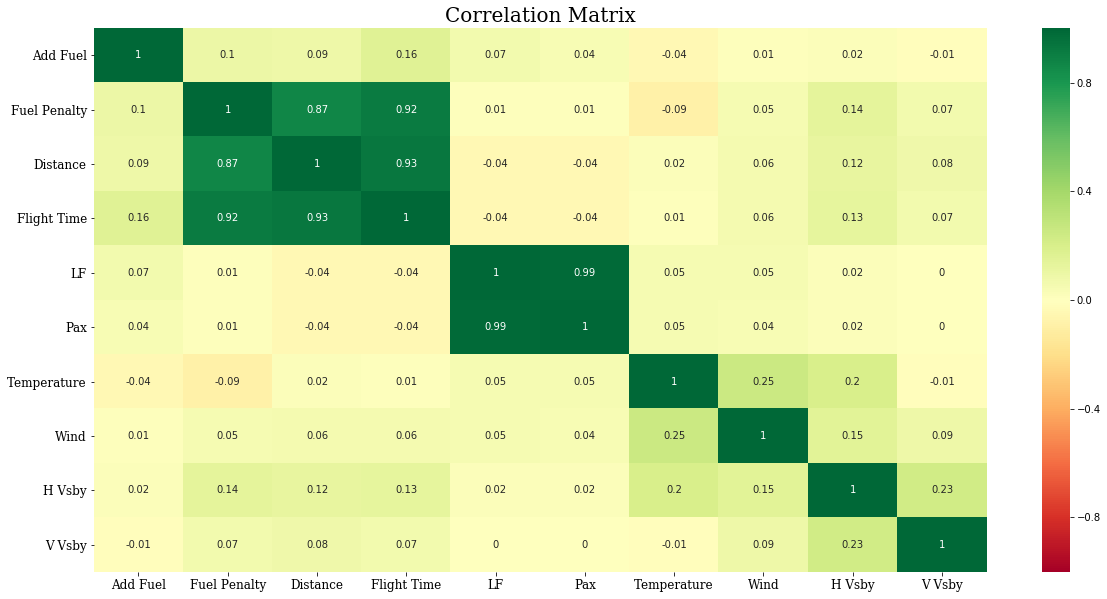

In [14]:
fig = plt.figure(figsize=(20,10))
ax=sns.heatmap(Master[con_var].corr().round(2), vmin=-1,vmax=1,annot = True,cmap="RdYlGn")
plt.xticks(family="serif",fontsize=12)
plt.yticks(family="serif",fontsize=12)
ax.set_title("Correlation Matrix",family="serif",fontsize=20)
plt.show()

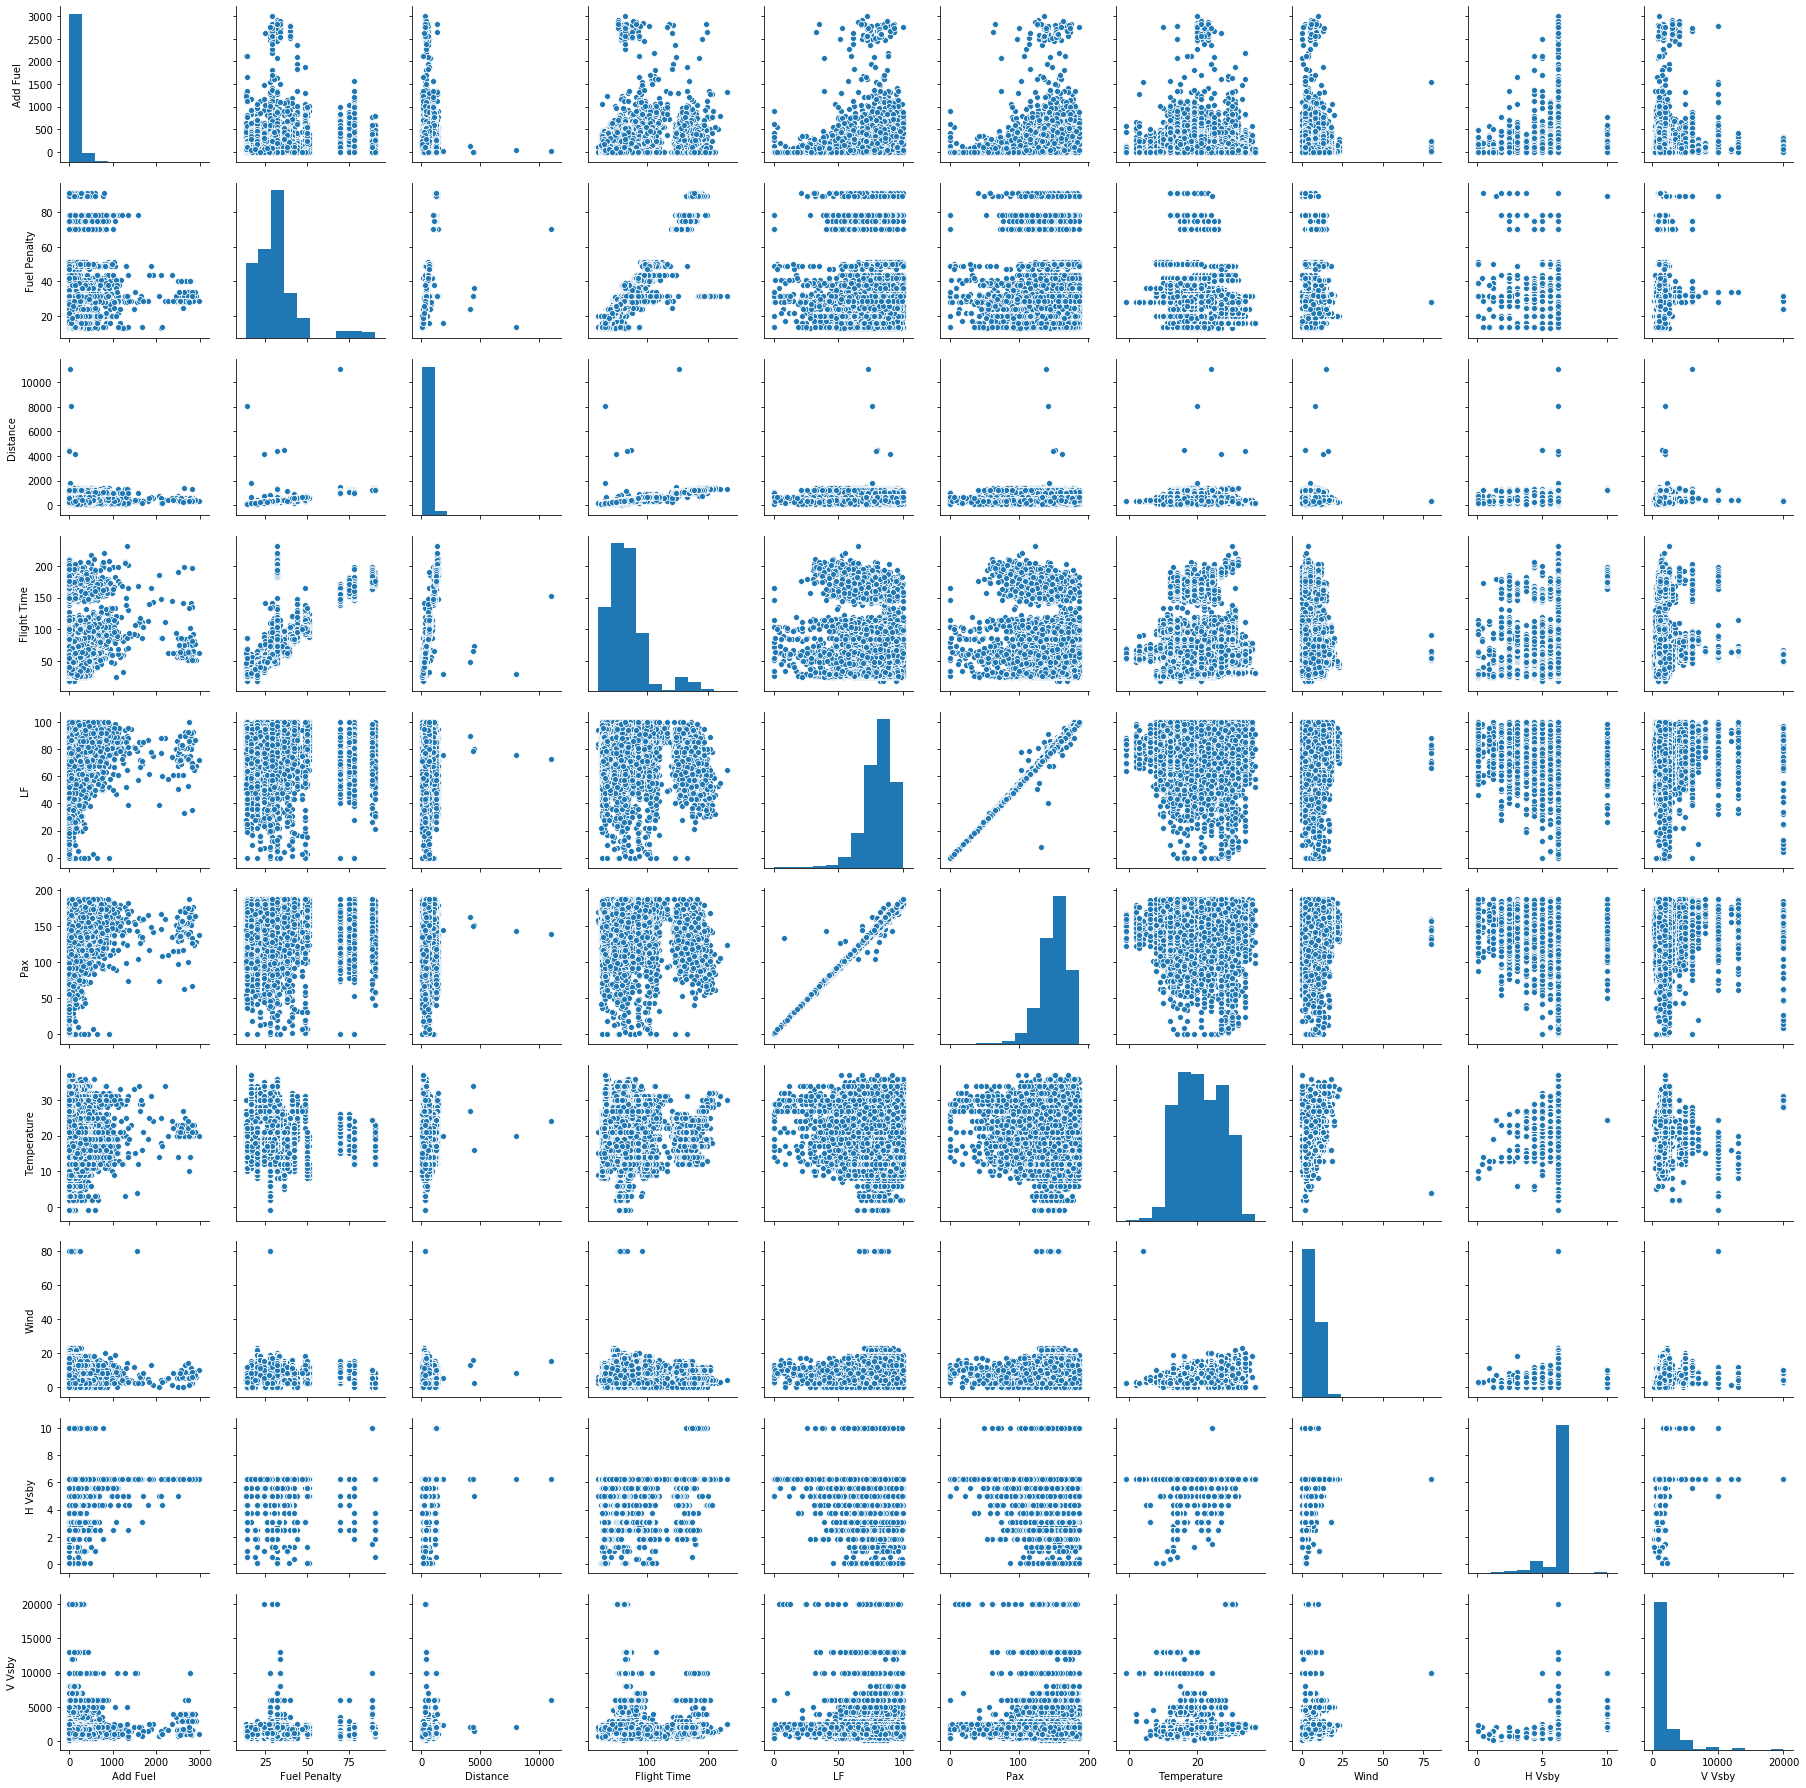

In [15]:
sns.pairplot(Master[con_var])

In [16]:
#Se eliminan variables redundantes que muestran fuerte correlación con otras, 

In [17]:
con_var=['Add Fuel',
         'Flight Time',
         'Pax','Temperature','Wind','H Vsby','V Vsby']

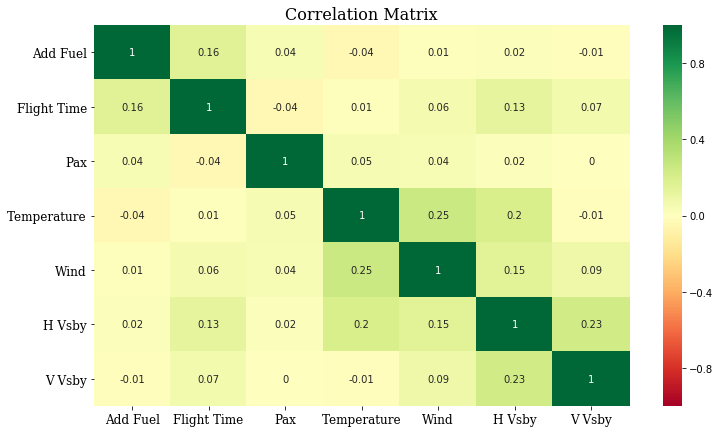

In [18]:
fig = plt.figure(figsize=(12,7))
ax=sns.heatmap(Master[con_var].corr().round(2), vmin=-1,vmax=1,annot = True,cmap="RdYlGn")
plt.xticks(family="serif",fontsize=12)
plt.yticks(family="serif",fontsize=12)
ax.set_title("Correlation Matrix",family="serif",fontsize=16)
plt.show()

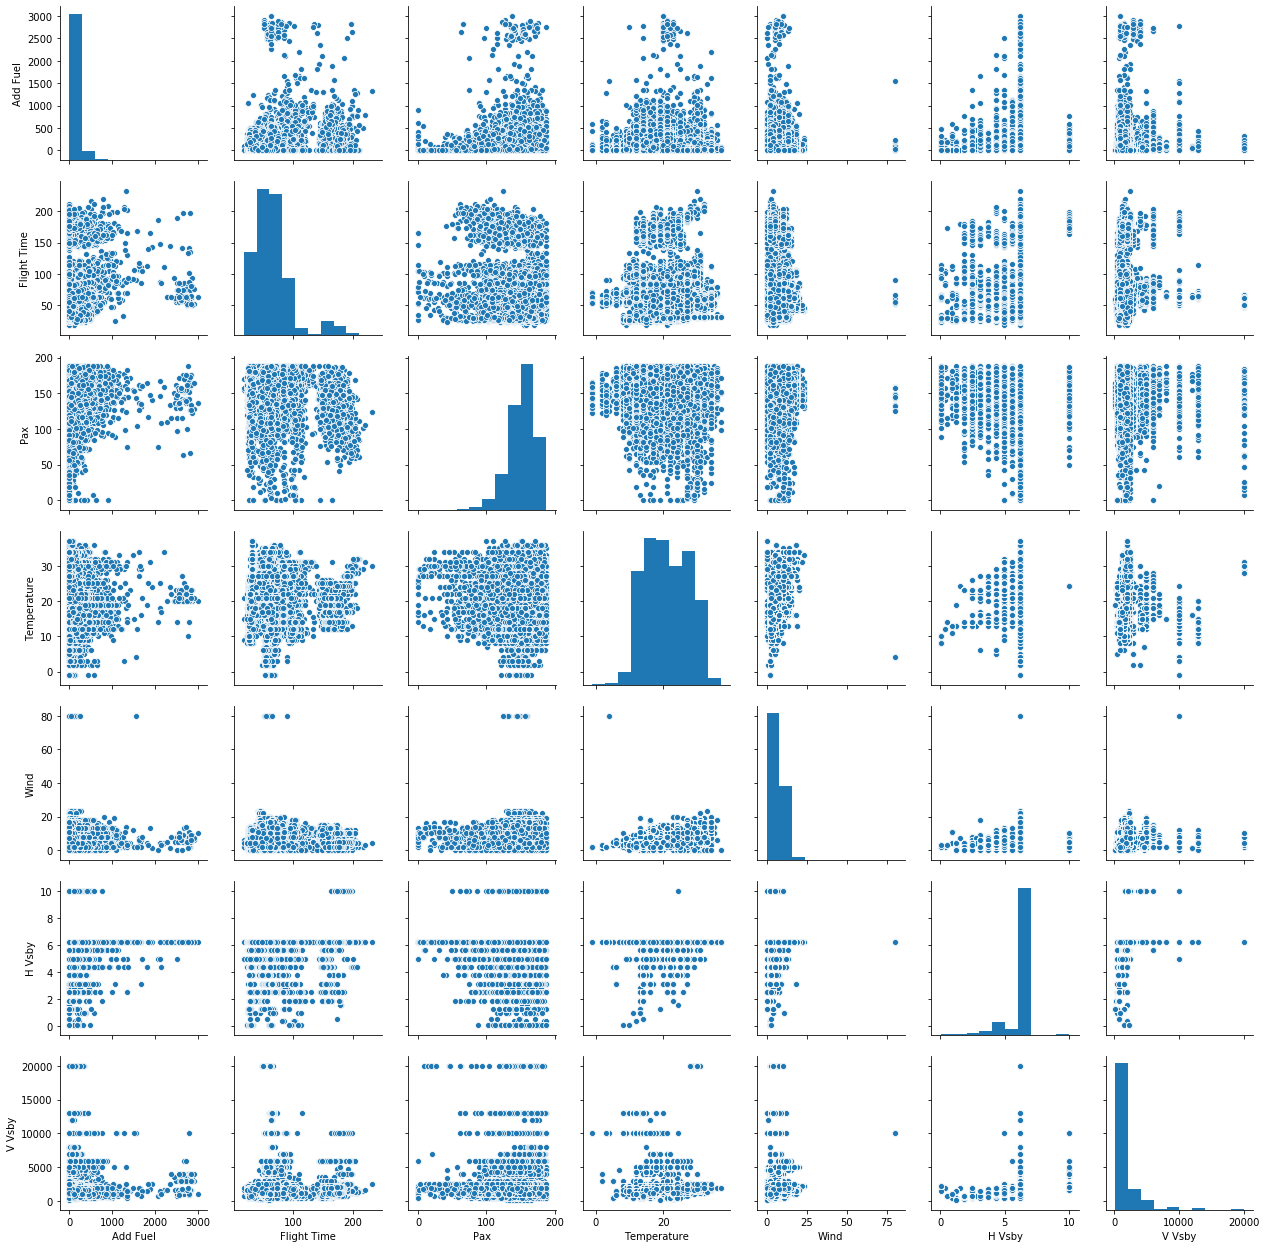

In [19]:
sns.pairplot(Master[con_var])

In [20]:
cat_var=['VVC','Rain','New AC', 'Fog-Brume','Long Flight Time', 'Thunder']

Null Hypothesis: Mean Add Fuel by categorical variable aren't significantly different
Perform t-test and determine the p-value


,T,P-value,Conclusion
VVC,-5.76,0.00,Significant
Rain,-1.66,0.10,No-significant
New AC,39.92,0.00,Significant
Fog-Brume,4.84,0.00,Significant
Long Flight Time,-15.72,0.00,Significant
Thunder,0.40,0.69,No-significant


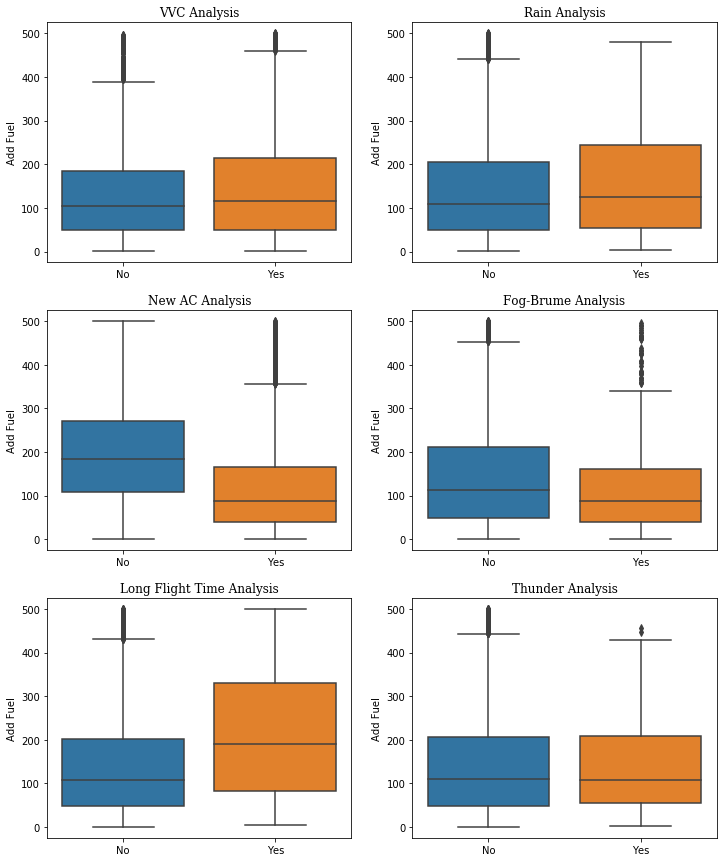

In [21]:
t={}
plt.figure(figsize=(12,15))
for i, var in enumerate(cat_var):
    plt.subplot(3,2,i+1)
    
    x=Master[(Master['Add Fuel Dummy']==1)&(Master['Add Fuel']<=Ref_value)][var]
    y=Master[(Master['Add Fuel Dummy']==1)&(Master['Add Fuel']<=Ref_value)]['Add Fuel']
    
    ax=sns.boxplot(x,y)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)
    ax.set_xticklabels(['No','Yes'])
    ax.set_title(var+" Analysis",family='serif',size=12)
    ax.set_xlabel("")
    
    #Hypothesis testing
    Yes=np.array(Master[(Master[var]==1)&(Master['Add Fuel']>0)&(Master['Add Fuel']<=Ref_value)]['Add Fuel'])
    No=np.array(Master[(Master[var]==0)&(Master['Add Fuel']>0)&(Master['Add Fuel']<=Ref_value)]['Add Fuel'])
    t[var]=np.array(stats.ttest_ind(No,Yes, equal_var=True))

print("Null Hypothesis: Mean Add Fuel by categorical variable aren't significantly different")
print("Perform t-test and determine the p-value")

hyp=pd.DataFrame(t).T.round(2).rename(columns={0:'T',1:'P-value'})
hyp['Conclusion']=['Significant' if x<0.05 else 'No-significant' for x in hyp['P-value']]

cat_vars=list(hyp[hyp['Conclusion']=='Significant'].index)

hyp

In [22]:
columns=['Add Fuel Dummy','Add Fuel Label','Add Fuel','Fuel Burn std','Fuel Burn Range','Flight Time',
         'Flight Time std','Flight Time Range','Pax','Temperature','Wind','H Vsby','V Vsby','VVC','New AC', 
         'Fog-Brume','Long Flight Time']

Master=Master[columns]
Master.to_excel("Master Data Base - Viva Air Models.xlsx")